In [1]:
import numpy as np
from numba import njit

In [2]:
def orthogonal_complement(x, normalize=False, threshold=1e-15):
    """Compute orthogonal complement of a matrix

    this works along axis zero, i.e. rank == column rank,
    or number of rows > column rank
    otherwise orthogonal complement is empty

    TODO possibly: use normalize='top' or 'bottom'

    """
    x = np.asarray(x)
    r, c = x.shape
    if r < c:
        import warnings
        warnings.warn('fewer rows than columns', UserWarning)

    # we assume svd is ordered by decreasing singular value, o.w. need sort
    s, v, d = np.linalg.svd(x)
    rank = (v > threshold).sum()

    oc = s[:, rank:]

    if normalize:
        k_oc = oc.shape[1]
        oc = oc.dot(np.linalg.inv(oc[:k_oc, :]))
    return oc

In [3]:

def pre_maxvol(matrix, rank):
    res = np.int64(np.zeros(rank))
    row_norms = np.linalg.norm(matrix, axis = 1) ** 2
    
    for k in range(rank):
        maxj = np.argmax(row_norms)
        res[k] = maxj
        oc = orthogonal_complement(matrix[res[:k+1]].T)
        row_norms = np.linalg.norm(matrix @ oc, axis = 1) ** 2
        row_norms[res[:k+1]] = -1
    return res

In [4]:
@njit
def search_start_columns(matrix, start_rows, threshold=1e-16):
    mat = matrix[start_rows]
    q, r = np.linalg.qr(mat)
    rank = len(start_rows)
    res = np.zeros(rank)
    cur_i = 0
    shift = 0
    for i in range(r.shape[1]):
        if np.sum(np.abs(r[:, i]) > threshold) > cur_i:
            res[cur_i] = i
            cur_i += 1
    return res

In [5]:
def maxvol_rows(matrix, start_rows, start_columns, eps=1e-3, max_iters=50):
    current_rows = start_rows
    current_columns = start_columns
    # начниаем поиск в строках
    inv_matrix = np.linalg.inv(matrix[current_rows, :][:, current_columns])
    
    swaps = 0
    
    for iter in range(max_iters):
        # домножаем на обратную
        search_matrix = inv_matrix @ matrix[current_rows, :]
        
        # ищем элемент по модулю больший единицы
        max_index = np.unravel_index(np.argmax(np.abs(search_matrix)), (len(current_rows), matrix.shape[1]))
    
        if np.abs(search_matrix[max_index[0], max_index[1]]) <= 1 + eps:
            # если попали сюда, значит, не нашли
            break
            
        swaps+= 1
        # обновляем столбец
        
        old_col = current_columns[max_index[0]]
        current_columns[max_index[0]] = max_index[1]
        
        # применяем формулу Шермана-Моррисона для обновления обратной матрицы
        u = matrix[current_rows, current_columns[max_index[0]]] - matrix[current_rows, old_col]
        v = np.zeros(len(current_rows))
        v[max_index[0]] = 1
        
        inv_matrix += inv_matrix - inv_matrix @ u[:, None] @ v[None, :] @ inv_matrix / \
                (1 + v[None, :] @ inv_matrix @ u[:, None])
        
    return (current_rows, current_columns, swaps)

In [6]:
def maxvol_columns(matrix, start_rows, start_columns, eps=1e-3, max_iters=50):
    current_rows = start_rows
    current_columns = start_columns
    # начниаем поиск в строках
    
    inv_matrix = np.linalg.inv(matrix[current_rows, :][:, current_columns])
    
    swaps = 0
    for iter in range(max_iters):
        # домножаем на обратную
        search_matrix = matrix[:, current_columns] @ inv_matrix
        
        # ищем элемент по модулю больший единицы
        max_index = np.unravel_index(np.argmax(np.abs(search_matrix)), (matrix.shape[0], len(current_columns)))
    
        if np.abs(search_matrix[max_index[0], max_index[1]]) <= 1 + eps:
            # если попали сюда, значит, не нашли
            break
        
        swaps += 1
        # обновляем столбец
        old_row = current_rows[max_index[1]]
        current_rows[max_index[1]] = max_index[0]
        
        # применяем формулу Шермана-Моррисона для обновления обратной матрицы
        u = np.zeros(len(current_columns))
        u[max_index[1]] = 1
        v = matrix[current_rows[max_index[1]], current_columns] - matrix[old_row, current_columns]
        
        inv_matrix += inv_matrix - inv_matrix @ u[:, None] @ v[None, :] @ inv_matrix / \
                (1 + v[None, :] @ inv_matrix @ u[:, None])
        
    return (current_rows, current_columns, swaps)

In [7]:
def maxvol(matrix, start_rows, start_columns, eps=1e-3, max_iters=50):
    current_rows = start_rows
    current_columns = start_columns
    swaps = 1
    while swaps: 
        current_rows, current_columns, swaps = maxvol_rows(matrix, current_rows, current_columns, eps, max_iters)
        if not swaps:
            break
        current_rows, current_columns, swaps = maxvol_columns(matrix, current_rows, current_columns, eps, max_iters)
    return current_rows, current_columns

In [8]:
def search_max_volume_submatrix(matrix, rank, eps=1e-4, zero_threshold=1e-16, max_iters=50):
    matrix = np.float64(matrix)
    # ищем неплохое начальное приближение
    start_rows = pre_maxvol(matrix, rank)

    start_columns = np.int64(search_start_columns(matrix, start_rows, zero_threshold))

    start_rows = np.sort(start_rows)
    start_columns = np.sort(start_columns)
    
    # запускаем maxvol на начальных данных
    return maxvol(matrix, start_rows, start_columns, eps, max_iters)

In [9]:
A = np.array([[(i + j) ** (-1) for j in range(1, 1001)] for i in range(1, 1001)]).reshape((1000, 1000))

In [10]:
error = np.zeros(10)

In [11]:
for i in range(1, 11):
    rows, cols = search_max_volume_submatrix(A, i)
    cross_approx = A[:, cols] @ np.linalg.inv(A[rows, :][:, cols]) @ A[rows, :]
    error[i - 1] = np.linalg.norm(A - cross_approx, ord=None)

In [12]:
rank = np.array(range(1, 11))

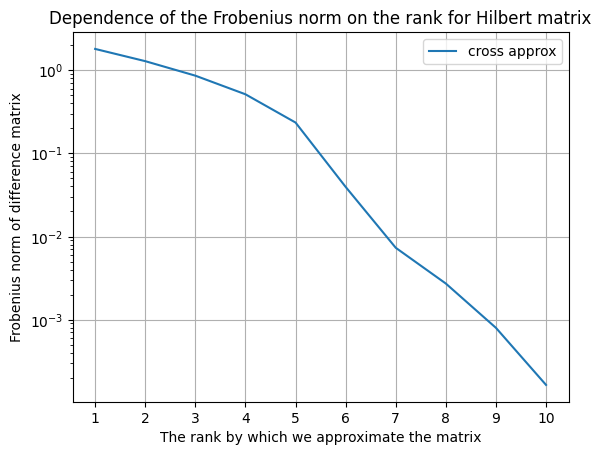

In [16]:
import matplotlib.pyplot as plt

plt.title("Dependence of the Frobenius norm on the rank for Hilbert matrix")
plt.plot(rank, error, label='cross approx')
plt.xlabel('The rank by which we approximate the matrix')
plt.ylabel('Frobenius norm of difference matrix')
plt.yscale('log')
plt.xticks(rank)
plt.legend()
plt.grid()
plt.savefig('./dependence_plot')